<a href="https://colab.research.google.com/github/ShreshthSaxena/Lung-Cancer-Prediction/blob/master/final_cnn_luna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#for connecting google drive to colab
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2315741968601569725
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 2088203118180351511
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 9934803885435823108
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11276946637
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2333970530344321913
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


In [2]:
#RAM INFO
!cat /proc/meminfo

MemTotal:       13335276 kB
MemFree:        10476296 kB
MemAvailable:   12196644 kB
Buffers:           72212 kB
Cached:          1804404 kB
SwapCached:            0 kB
Active:           894712 kB
Inactive:        1599580 kB
Active(anon):     588684 kB
Inactive(anon):     2400 kB
Active(file):     306028 kB
Inactive(file):  1597180 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:               972 kB
Writeback:             0 kB
AnonPages:        617692 kB
Mapped:           408992 kB
Shmem:              2948 kB
Slab:             156076 kB
SReclaimable:     116468 kB
SUnreclaim:        39608 kB
KernelStack:        4112 kB
PageTables:         6492 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:     6667636 kB
Committed_AS:    2251900 kB
VmallocTotal:   34359738367 kB
VmallocUsed:           0 kB
VmallocChunk:          0 kB
AnonHugePages:         0 kB
ShmemHugePages:  

In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [11]:
cd "My Drive"

/content/gdrive/My Drive


In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
import os
os.chdir("drive/cnn-luna (6e89a3eb)")
#Connection process ends here

In [13]:
#importing libraries
#import os
import numpy as np
import imageio
import matplotlib.pyplot as plt
import tensorflow as tf
from glob import glob
from datetime import datetime
from collections import OrderedDict
#import shutil
import time
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
#from keras.preprocessing.image import ImageDataGenerator
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.callbacks import TensorBoard


Using TensorFlow backend.


In [0]:
#diferent parameters used
IMAGE_SIZE = 40 # image width , height 
NUM_CHANNELS = 1 # as the image is in grayscale format,it would be 3 for RGB
NUM_CLASSES = 2 # binary classification
NUM_TRAIN_EXAMPLES = 2064
NUM_VALIDATION_EXAMPLES = 442
NUM_TEST_EXAMPLES = 442
BATCH_SIZE = 104
NUM_ITERS = 251
DROPOUT_RATE = 0.2
KEEP_PROB = 1 - DROPOUT_RATE
JPEG_IMAGE_DIR = 'data/LUNA2016/images/'
CONV1_NUM_FILTERS = 16
CONV1_KERNEL_SIZE = [3, 3]
CONV1_STRIDE = 1
CONV1_PADDING = 'SAME' #with zero padding
CONV1_ACTIV_FUNC = tf.nn.relu
POOL1_FILTER_SIZE = [2, 2]
POOL1_STRIDE = 2
POOL1_PADDING = 'SAME'

CONV2_NUM_FILTERS = 32
CONV2_KERNEL_SIZE = [5, 5]
CONV2_STRIDE = 1
CONV2_PADDING = 'SAME'
CONV2_ACTIV_FUNC = tf.nn.relu
POOL2_FILTER_SIZE = [2, 2]
POOL2_STRIDE = 2
POOL2_PADDING = 'SAME'

CONV3_NUM_FILTERS = 64
CONV3_KERNEL_SIZE = [7, 7]
CONV3_STRIDE = 1
CONV3_PADDING = 'SAME'
CONV3_ACTIV_FUNC = tf.nn.relu
POOL3_FILTER_SIZE = [2, 2]
POOL3_STRIDE = 2
POOL3_PADDING = 'SAME'
CONV4_NUM_FILTERS = 64
CONV4_KERNEL_SIZE = [7, 7]
CONV4_STRIDE = 1
CONV4_PADDING = 'SAME'
CONV4_ACTIV_FUNC = tf.nn.relu
POOL4_FILTER_SIZE = [2, 2]
POOL4_STRIDE = 2
POOL4_PADDING = 'SAME'
FC1_NUM_NEURONS = 1024
FC1_ACTIV_FUNC = tf.nn.relu

In [0]:
#definition of the function which imports the dataset
def import_data():
    image_list = glob(JPEG_IMAGE_DIR + "*.png")
    num_images = len(image_list)
    images = np.zeros((num_images, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS), dtype=np.float32)
    labels = np.zeros((num_images, NUM_CLASSES), dtype=np.float32)
    for i, filename in enumerate(image_list):
        # importing image data and converting to numpy array of proper size
        image = imageio.imread(filename)
        image = image.astype(np.float32)
        image = 1 - image/255 # convert pixels from range [0, 255] to [0.0, 1.0]
        image = image[:, :, np.newaxis] 
        images[i] = image
        print("\ni=",i)
        print("filename=",filename)
        # importing labels and assigning to correct class:
        classification = filename[-7:-4]
        if classification == 'pos':
            labels[i] = np.array([1.0, 0.0])
        elif classification == 'neg':
            labels[i] = np.array([0.0, 1.0])
        else:
            print( "ERROR: classification cannot be determined from filename:", filename)
            assert False

    # zero-center data over entire dataset (ONLY FOR TRAINING SET, subtract same mean value for test/validation sets)
    images -= np.mean(images[0:NUM_TRAIN_EXAMPLES, :, :, :])

    # spliting image data into three different sets, viz train, validation, and test sets
    idx1 = NUM_TRAIN_EXAMPLES
    idx2 = NUM_TRAIN_EXAMPLES + NUM_VALIDATION_EXAMPLES
    idx3 = NUM_TRAIN_EXAMPLES + NUM_VALIDATION_EXAMPLES + NUM_TEST_EXAMPLES

    train_data = images[0:idx1, :, :, :]
    validation_data = images[idx1:idx2, :, :, :]
    test_data = images[idx2:idx3, :, :, :]
    train_labels = labels[0:idx1]
    validation_labels = labels[idx1:idx2]
    test_labels = labels[idx2:idx3]
    test_image_filenames = image_list[idx2:idx3]
    
    return train_data, validation_data, test_data, train_labels, validation_labels, test_labels, test_image_filenames

In [23]:
#fetching data
train_data, validation_data, test_data, train_labels, validation_labels, test_labels, test_images_filenames = import_data()


i= 0
filename= data/LUNA2016/images/1.3.6.1.4.1.14519.5.2.1.6279.6001.299767339686526858593516834230nod1slc1neg.png

i= 1
filename= data/LUNA2016/images/1.3.6.1.4.1.14519.5.2.1.6279.6001.299767339686526858593516834230nod1slc1pos.png

i= 2
filename= data/LUNA2016/images/1.3.6.1.4.1.14519.5.2.1.6279.6001.299767339686526858593516834230nod2slc0neg.png

i= 3
filename= data/LUNA2016/images/1.3.6.1.4.1.14519.5.2.1.6279.6001.299767339686526858593516834230nod2slc0pos.png

i= 4
filename= data/LUNA2016/images/1.3.6.1.4.1.14519.5.2.1.6279.6001.299767339686526858593516834230nod1slc0neg.png

i= 5
filename= data/LUNA2016/images/1.3.6.1.4.1.14519.5.2.1.6279.6001.299767339686526858593516834230nod1slc0pos.png

i= 6
filename= data/LUNA2016/images/1.3.6.1.4.1.14519.5.2.1.6279.6001.299767339686526858593516834230nod2slc1neg.png

i= 7
filename= data/LUNA2016/images/1.3.6.1.4.1.14519.5.2.1.6279.6001.299767339686526858593516834230nod2slc1pos.png

i= 8
filename= data/LUNA2016/images/1.3.6.1.4.1.14519.5.2.1.627

In [0]:
#CNN model as a function

def modrun():

        input_shape = (40,40,1)
        
        model = Sequential()
        img_width, img_height = 40, 40
        
        #convolution layer 1
        model.add(Conv2D(CONV1_NUM_FILTERS, kernel_size=(CONV1_KERNEL_SIZE[0],CONV1_KERNEL_SIZE[1]), strides=(1, 1), padding = 'same',
                 activation='relu',data_format="channels_last"))
      
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2),padding = 'same'))
        
        #convolution layer 2
        model.add(Conv2D(CONV2_NUM_FILTERS, kernel_size=(CONV2_KERNEL_SIZE[0],CONV2_KERNEL_SIZE[1]), strides=(1, 1), padding = 'same',
                 activation='relu'))        

        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2),padding = 'same'))

        #convolution layer 3
        model.add(Conv2D(CONV3_NUM_FILTERS, kernel_size=(CONV3_KERNEL_SIZE[0],CONV3_KERNEL_SIZE[1]), strides=(1, 1), padding = 'same',
                 activation='relu'))        

        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2),padding = 'same'))
                
        
        # densely connected layer
        # image size has been reduced to 10x10 so we will add a fully-connected layer with 1024 neurons
        model.add(Flatten())
        
        model.add(Dense(1024, activation='relu'))

        # dropout
        model.add(Dropout(0.2))

        # readout layer
        model.add(Dense(1))
        
        model.add(Activation('sigmoid'))
        

        model.compile(loss='binary_crossentropy', # or categorical_crossentropy
                      optimizer='Adam',
                      metrics=['accuracy']) 

        return model

In [31]:
print( "Train Data Size", train_data.shape)
print ("Train Labels Size", train_labels.shape)
print ("Validation Data Size", validation_data.shape)
print ("Validation Labels Size", validation_labels.shape)
print ("Test Data Size", test_data.shape)
print ("Test Labels Size", test_labels.shape)

from keras.models import load_model
model = load_model('cancerCNN.h5')
print(model.summary())

Train Data Size (2064, 40, 40, 1)
Train Labels Size (2064, 2)
Validation Data Size (442, 40, 40, 1)
Validation Labels Size (442, 2)
Test Data Size (442, 40, 40, 1)
Test Labels Size (442, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 40, 40, 16)        160       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 20, 20, 16)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 20, 20, 32)        12832     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 10, 10, 64)        100416    
_________________________________________________________________
max_pooling2d_6 (M

In [18]:
#for tensorboard diagram
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

--2019-02-14 18:53:51--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.72.245.79, 52.7.169.168, 52.73.9.93, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.72.245.79|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5363700 (5.1M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]   5.11M  15.8MB/s    in 0.3s    

2019-02-14 18:53:51 (15.8 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [5363700/5363700]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [0]:
LOG_DIR = './log'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

In [0]:
get_ipython().system_raw('./ngrok_new_f1 http 6006 &')

In [21]:
#generating link
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/usr/lib/python3.6/json/__init__.py", line 299, in load
    parse_constant=parse_constant, object_pairs_hook=object_pairs_hook, **kw)
  File "/usr/lib/python3.6/json/__init__.py", line 354, in loads
    return _default_decoder.decode(s)
  File "/usr/lib/python3.6/json/decoder.py", line 339, in decode
    obj, end = self.raw_decode(s, idx=_w(s, 0).end())
  File "/usr/lib/python3.6/json/decoder.py", line 357, in raw_decode
    raise JSONDecodeError("Expecting value", s, err.value) from None
json.decoder.JSONDecodeError: Expecting value: line 1 column 1 (char 0)


In [0]:
batch_size = 300

tbCallBack = TensorBoard(log_dir='./log', histogram_freq=1,
                         write_graph=True,
                         write_grads=True,
                         batch_size=batch_size,
                         write_images=True)

In [0]:
#execution of the model
model = modrun()
epochs = 45
batch_size = 300
        
#fitting the model with train data and validating on validation data
model.fit(train_data, train_labels[:,0],validation_data=(validation_data, validation_labels[:,0]), epochs=epochs, batch_size = batch_size,callbacks = [tbCallBack])
        
#evaluating the trained model with test data
score = model.evaluate(test_data, test_labels[:,0], verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 2064 samples, validate on 442 samples
Epoch 1/45
2064/2064 [==============================] - 3s 2ms/step - loss: 0.5902 - acc: 0.6623 - val_loss: 0.4433 - val_acc: 0.8009
Epoch 2/45
2064/2064 [==============================] - 0s 98us/step - loss: 0.4432 - acc: 0.7999 - val_loss: 0.4425 - val_acc: 0.7738
Epoch 3/45
2064/2064 [==============================] - 0s 104us/step - loss: 0.3807 - acc: 0.8343 - val_loss: 0.3614 - val_acc: 0.8416
Epoch 4/45
2064/2064 [==============================] - 0s 96us/step - loss: 0.3108 - acc: 0.8740 - val_loss: 0.2822 - val_acc: 0.8869
Epoch 5/45
2064/2064 [==============================] - 0s 94us/step - loss: 0.2598 - acc: 0.9026 - val_loss: 0.2424 - val_acc: 0.9118
Epoch 6/45
2064/2064 [==============================] - 0s 95us/step - loss: 0.2251 - acc: 0.9138 - val_loss: 0.2135 - val_acc: 0.9186
Epoch 7/45
2064/2064 [==============================] - 0s 93us/step - loss: 0.1859 - acc: 0.9370 - val_loss: 0.1891 - val_acc: 0.9299
Epoch 8/

Convolution layer:  1  Chhanel No:  1


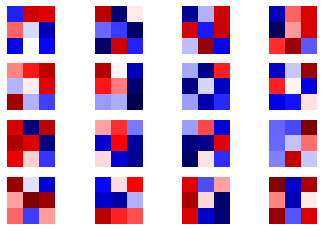

Convolution layer:  2  Chhanel No:  1


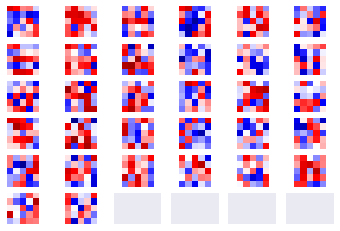

Convolution layer:  2  Chhanel No:  2


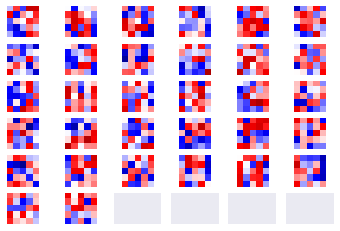

Convolution layer:  2  Chhanel No:  3


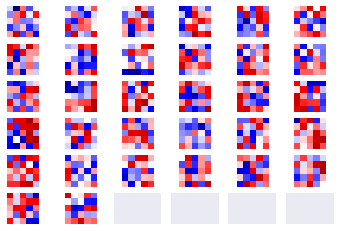

Convolution layer:  2  Chhanel No:  4


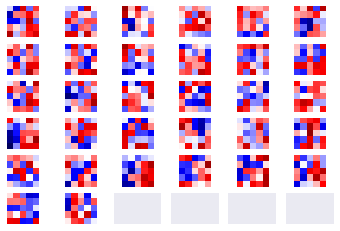

Convolution layer:  2  Chhanel No:  5


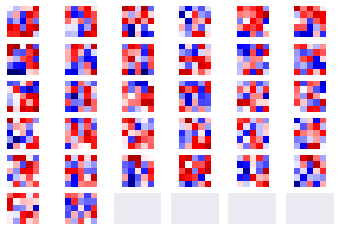

Convolution layer:  2  Chhanel No:  6


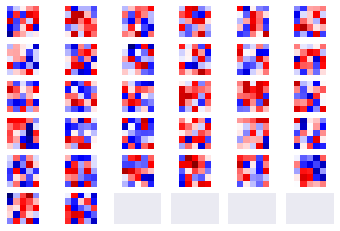

Convolution layer:  2  Chhanel No:  7


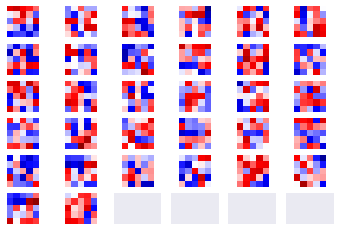

Convolution layer:  2  Chhanel No:  8


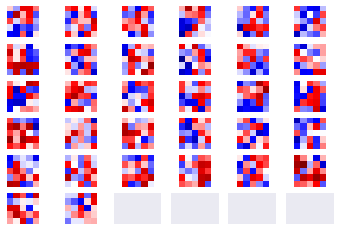

Convolution layer:  2  Chhanel No:  9


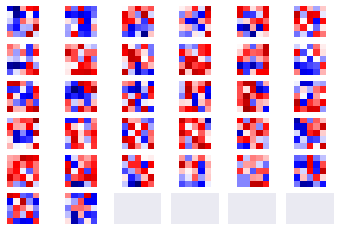

Convolution layer:  2  Chhanel No:  10


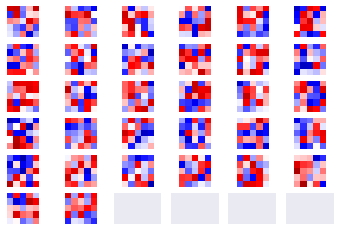

Convolution layer:  2  Chhanel No:  11


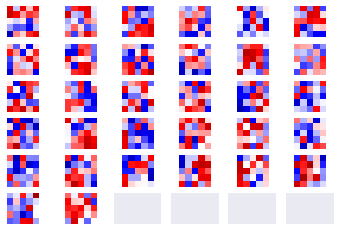

Convolution layer:  2  Chhanel No:  12


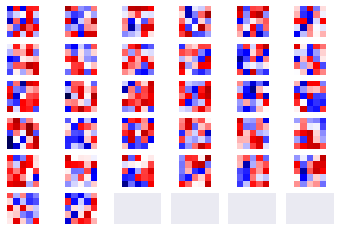

Convolution layer:  2  Chhanel No:  13


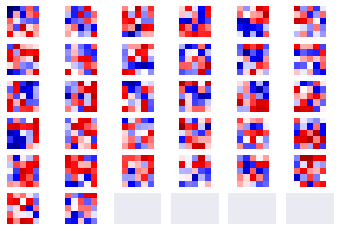

Convolution layer:  2  Chhanel No:  14


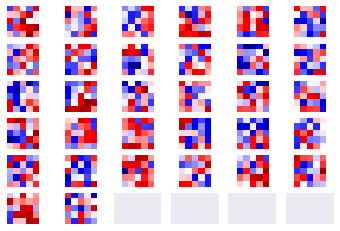

Convolution layer:  2  Chhanel No:  15


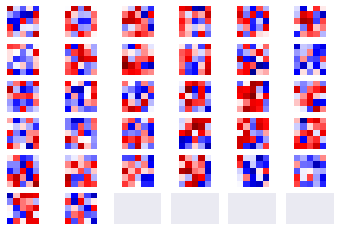

Convolution layer:  2  Chhanel No:  16


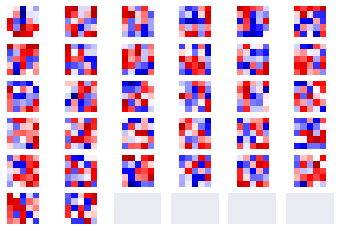

Convolution layer:  3  Chhanel No:  1


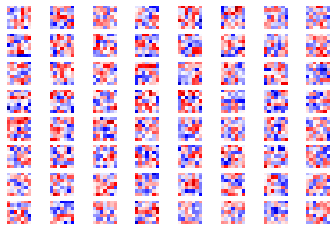

Convolution layer:  3  Chhanel No:  2


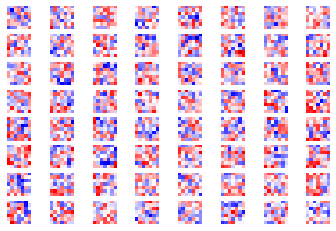

Convolution layer:  3  Chhanel No:  3


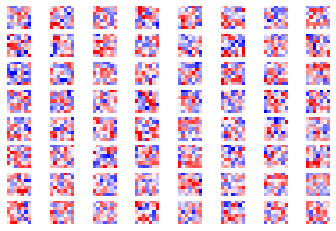

Convolution layer:  3  Chhanel No:  4


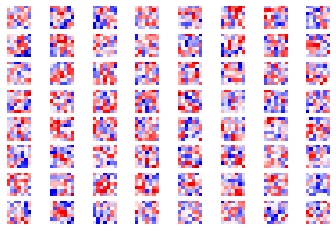

Convolution layer:  3  Chhanel No:  5


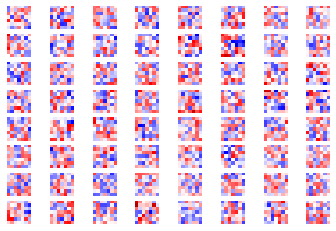

Convolution layer:  3  Chhanel No:  6


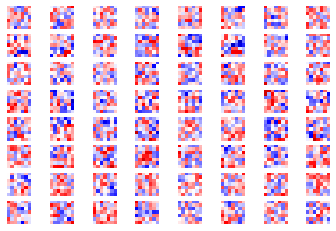

Convolution layer:  3  Chhanel No:  7


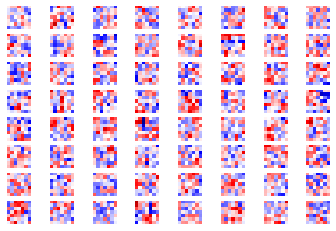

Convolution layer:  3  Chhanel No:  8


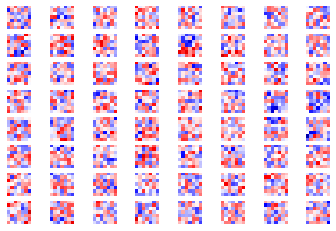

Convolution layer:  3  Chhanel No:  9


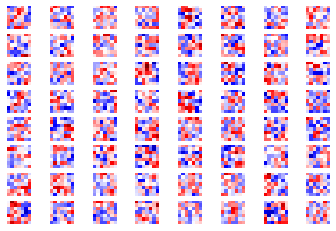

Convolution layer:  3  Chhanel No:  10


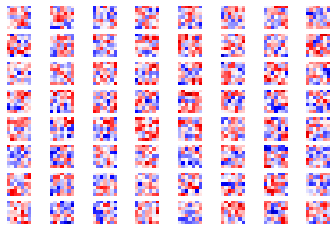

Convolution layer:  3  Chhanel No:  11


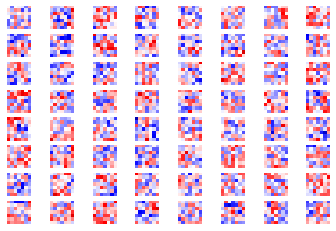

Convolution layer:  3  Chhanel No:  12


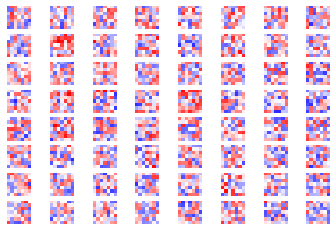

Convolution layer:  3  Chhanel No:  13


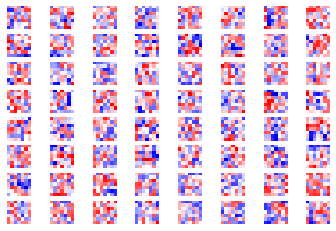

Convolution layer:  3  Chhanel No:  14


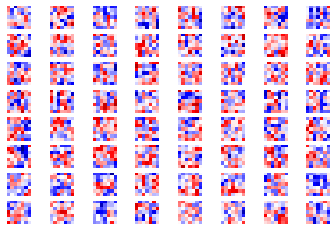

Convolution layer:  3  Chhanel No:  15


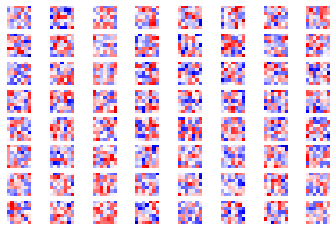

Convolution layer:  3  Chhanel No:  16


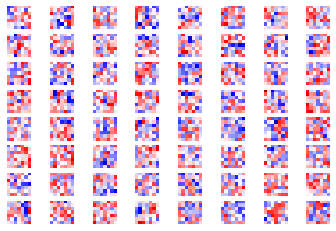

Convolution layer:  3  Chhanel No:  17


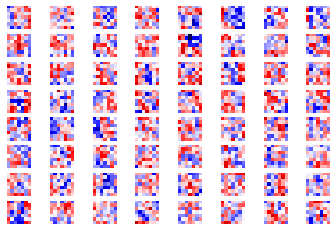

Convolution layer:  3  Chhanel No:  18


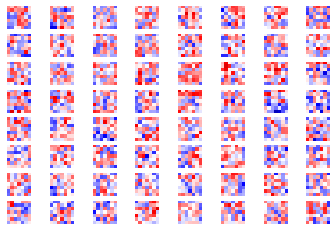

Convolution layer:  3  Chhanel No:  19


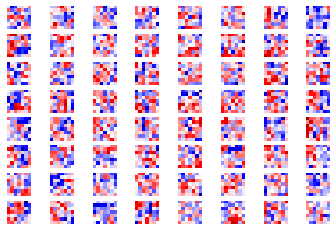

Convolution layer:  3  Chhanel No:  20


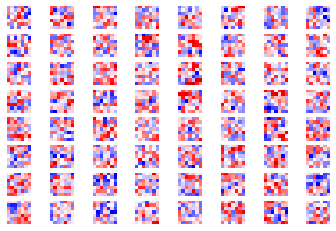

Convolution layer:  3  Chhanel No:  21


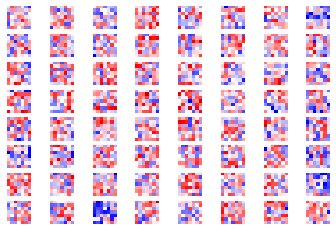

Convolution layer:  3  Chhanel No:  22


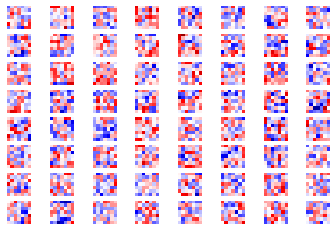

Convolution layer:  3  Chhanel No:  23


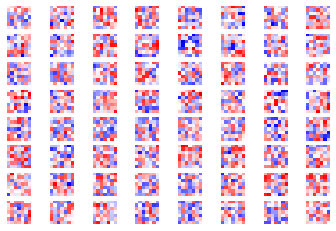

Convolution layer:  3  Chhanel No:  24


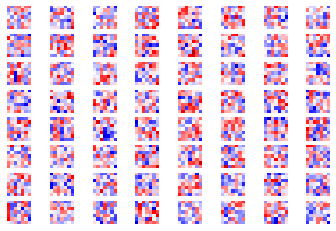

Convolution layer:  3  Chhanel No:  25


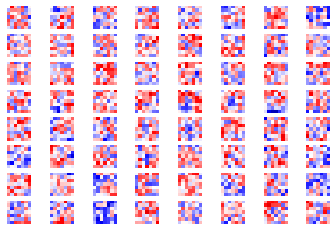

Convolution layer:  3  Chhanel No:  26


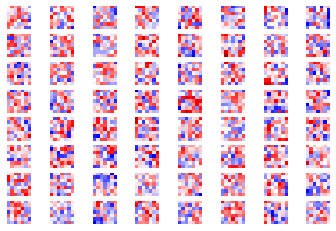

Convolution layer:  3  Chhanel No:  27


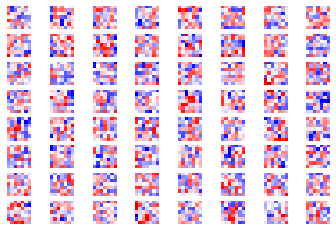

Convolution layer:  3  Chhanel No:  28


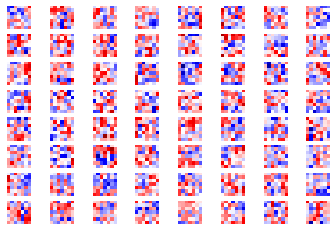

Convolution layer:  3  Chhanel No:  29


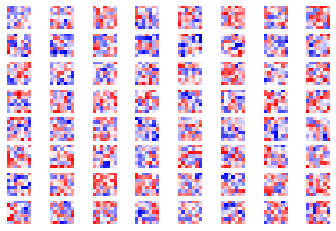

Convolution layer:  3  Chhanel No:  30


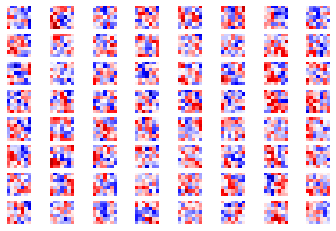

Convolution layer:  3  Chhanel No:  31


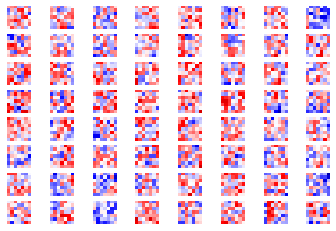

Convolution layer:  3  Chhanel No:  32


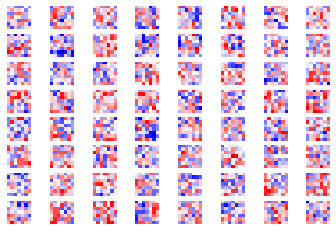

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import math
def plot_conv_weights(weights, input_channel=0):
    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(weights)
    w_max = np.max(weights)

    # Number of filters used in the conv. layer.
    num_filters = weights.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)
   

    # Plot all the filter-weights.
    for i, ax in enumerate(axes.flat):
        # Only plot the valid filter-weights.
        if i<num_filters:
            # Get the weights for the i'th filter of the input channel.
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor.
            img = weights[:, :, input_channel, i]

            # Plot image.
            ax.imshow(img, vmin=w_min, vmax=w_max,
                      interpolation='nearest', cmap='seismic')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.

    plt.show()

    

nb_channels = 1,CONV1_NUM_FILTERS,CONV2_NUM_FILTERS

for i in range(0,3):
  weights_conv_layers = model.layers[i*2].get_weights()[0]
  for j in range(0,nb_channels[i]):
    print("Convolution layer: " ,i+1," Chhanel No: ",j+1)
    plot_conv_weights(weights=weights_conv_layers, input_channel=j)


In [49]:
model.evaluate(test_data, test_labels[:,0])

442/442 [==============================] - 0s 162us/step


[0.21940971263663261, 0.9162895914116597]

In [0]:
#definition of confusion matrix
def confusion_matrix(pred_arr,test_labels):
  fp = 0
  tp = 0
  fn = 0
  tn = 0
  r,c = pred_arr.shape
  for i in range(0,r):
    if (int)(pred_arr[i]) == test_labels[i]:
      if (int)(pred_arr[i]) == 1:
        tp = tp + 1;
      else:
        tn = tn + 1;
    else:
      if (int)(pred_arr[i]) == 1:
        fp = fp + 1;
      else: 
        fn = fn + 1 ;
  print("True Positive:",tp,
       "\nFalse Positive:",fp,
       "\nTrue Negative:",tn,
       "\nFalse Negative:",fn)
  return tp,fp,tn,fn

In [0]:
pre = model.predict(test_data)
pre = pre > 0.5
tp,fp,tn,fn = confusion_matrix(pre,test_labels[:,0])

True Positive: 208 
False Positive: 5 
True Negative: 226 
False Negative: 3


In [50]:
model.get_config()

{'build_input_shape': [None, 40, 40, 1],
 'layers': [{'class_name': 'Conv2D',
   'config': {'activation': 'relu',
    'activity_regularizer': None,
    'bias_constraint': None,
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'bias_regularizer': None,
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'filters': 16,
    'kernel_constraint': None,
    'kernel_initializer': {'class_name': 'VarianceScaling',
     'config': {'distribution': 'uniform',
      'mode': 'fan_avg',
      'scale': 1.0,
      'seed': None}},
    'kernel_regularizer': None,
    'kernel_size': (3, 3),
    'name': 'conv2d_31',
    'padding': 'same',
    'strides': (1, 1),
    'trainable': True,
    'use_bias': True}},
  {'class_name': 'MaxPooling2D',
   'config': {'data_format': 'channels_last',
    'name': 'max_pooling2d_4',
    'padding': 'same',
    'pool_size': (2, 2),
    'strides': (2, 2),
    'trainable': True}},
  {'class_name': 'Conv2D',
   'config': {'activation': 'relu',

In [0]:
#fuction for grid search
def create_network(optimizer='adam'):
    
        input_shape = (40,40,1)
        batch_size = 104
        model = Sequential()
        img_width, img_height = 40, 40
        model.add(Conv2D(CONV1_NUM_FILTERS, kernel_size=(CONV1_KERNEL_SIZE[0],CONV1_KERNEL_SIZE[1]), strides=(1, 1), padding = 'same',
                 activation='relu',
                 input_shape=input_shape))
      
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2),padding = 'same'))
        
        model.add(Conv2D(CONV2_NUM_FILTERS, kernel_size=(CONV2_KERNEL_SIZE[0],CONV2_KERNEL_SIZE[1]), strides=(1, 1), padding = 'same',
                 activation='relu'))        

        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2),padding = 'same'))

        model.add(Conv2D(CONV3_NUM_FILTERS, kernel_size=(CONV3_KERNEL_SIZE[0],CONV3_KERNEL_SIZE[1]), strides=(1, 1), padding = 'same',
                 activation='relu'))        

        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2),padding = 'same'))
                
        
        # densely connected layer
        # image size has been reduced to 10x10 so we will add a fully-connected layer with 1024 neurons
        model.add(Flatten())
        model.add(Dense(1024, activation='relu'))

        # dropout
        model.add(Dropout(0.2))

        # readout layer
        model.add(Dense(1))
        model.add(Activation('sigmoid'))

        # Compile neural network
        model.compile(loss='binary_crossentropy', # Cross-entropy
                    optimizer=optimizer, # Optimizer
                    metrics=['accuracy']) # Accuracy performance metric
    
        # Return compiled network
        return model

In [26]:
neural_network = KerasClassifier(build_fn=create_network, verbose=1)
# Create hyperparameter space
epochs = [40,45]
batches = [150,250,300]
optimizers = ['adam']
trd = np.concatenate((train_data, validation_data), axis=0)
ted = np.concatenate((train_labels[:,0], validation_labels[:,0]), axis=0)
# Create hyperparameter options
hyperparameters = dict(optimizer=optimizers, epochs=epochs, batch_size=batches)
# Create grid search
grid = GridSearchCV(cv=3,estimator=neural_network, param_grid=hyperparameters)

# Fit grid search
grid_result = grid.fit(trd, ted)
#grid_result = grid.fit(t, t_labels[:,0],validation_data=(validation_data, validation_labels[:,0]))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/40
1670/1670 [==============================] - 4s 2ms/step - loss: 0.5527 - acc: 0.6982
Epoch 2/40
1670/1670 [==============================] - 0s 135us/step - loss: 0.3869 - acc: 0.8269
Epoch 3/40
1670/1670 [==============================] - 0s 125us/step - loss: 0.2944 - acc: 0.8760
Epoch 4/40
1670/1670 [==============================] - 0s 117us/step - loss: 0.2332 - acc: 0.9060
Epoch 5/40
1670/1670 [==============================] - 0s 119us/step - loss: 0.1822 - acc: 0.9353
Epoch 6/40
1670/1670 [==============================] - 0s 119us/step - loss: 0.1803 - acc: 0.9269
Epoch 7/40
1670/1670 [==============================] - 0s 117us/step - loss: 0.1405 - acc: 0.9491
Epoch 8/40
1670/1670 [==============================] - 0s 123us/step - lo

In [27]:
best_para = grid_result.best_params_
print("best parameters:",best_para)
best_est = grid_result.best_estimator_

# Fit the best algorithm to the data. 
best_est.fit(train_data, train_labels[:,0], validation_data=(validation_data, validation_labels[:,0]))
acc = best_est.score(test_data, test_labels[:,0])
print("accuracy: {:5.2f}%".format(100*acc))

best parameters: {'batch_size': 300, 'epochs': 45, 'optimizer': 'adam'}
Train on 2064 samples, validate on 442 samples
Epoch 1/45
2064/2064 [==============================] - 3s 1ms/step - loss: 0.5912 - acc: 0.6478 - val_loss: 0.4246 - val_acc: 0.7602
Epoch 2/45
2064/2064 [==============================] - 0s 107us/step - loss: 0.4431 - acc: 0.8009 - val_loss: 0.4138 - val_acc: 0.8235
Epoch 3/45
2064/2064 [==============================] - 0s 101us/step - loss: 0.3609 - acc: 0.8522 - val_loss: 0.4541 - val_acc: 0.8348
Epoch 4/45
2064/2064 [==============================] - 0s 99us/step - loss: 0.2919 - acc: 0.8803 - val_loss: 0.3765 - val_acc: 0.8529
Epoch 5/45
2064/2064 [==============================] - 0s 97us/step - loss: 0.2147 - acc: 0.9264 - val_loss: 0.4278 - val_acc: 0.8484
Epoch 6/45
2064/2064 [==============================] - 0s 98us/step - loss: 0.1809 - acc: 0.9346 - val_loss: 0.4035 - val_acc: 0.8529
Epoch 7/45
2064/2064 [==============================] - 0s 97us/step -

In [0]:
from keras import backend as K
import math
input_shape = (40,40,1)

def plot_conv_output(values):
    # Number of filters used in the conv. layer.
    num_filters = values.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot the output images of all the filters.
    for i, ax in enumerate(axes.flat):
        # Only plot the images for valid filters.
        if i<num_filters:
            # Get the output image of using the i'th filter.
            img = values[0, :, :, i]

            # Plot image.
            ax.imshow(img, interpolation='nearest', cmap='binary')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

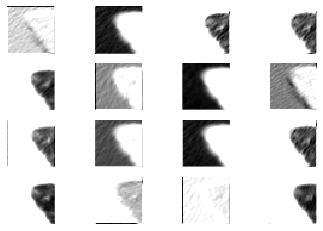

In [53]:
output_conv1 = K.function(inputs=[model.input],
                          outputs=[model.layers[0].output])
image1 = test_data[1]
layer_output1 = output_conv1([[image1]])[0]
plot_conv_output(values=layer_output1)


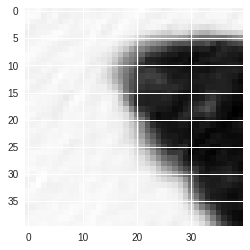

In [54]:
plt.imshow(np.squeeze(test_data[1]))